## Generating Names with a Character-level Language Modelling
* Dataset use: Dinosaur names [dataset](../input/dinos.txt)
* Language modelling: Character-level language modelling
* Dataset size: 19909 Names
* Character vocabulary size: 26

In [1]:
from __future__ import unicode_literals, print_function, division
import numpy as np 
import pandas as pd 
from io import open
import glob
import unicodedata
import string
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

['dinos.txt']


## Load the data
Following code will read the dataset of dinosaur names, creates a list of unique characters (such as a-z) or vocabulary, and compute the dataset and vocabulary size.

In [2]:
data = open("../input/dinos.txt", "r").read()
data = data.lower()
chars = list(sorted(set(data)))
chars.pop(0) #remove \n character
data_size, chars_size = len(data), len(chars)

print(chars, "Data size: {}".format(data_size), "Chars length: {}".format(chars_size))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] Data size: 19909 Chars length: 26


### Store data in a list

In [3]:
with open("../input/dinos.txt") as f:
    examples = f.readlines()
examples = [x.lower().strip() for x in examples]

In the cell below, we create a python dictionary to map each character to an index from 0-26. We also create a second python dictionary that maps each index back to the corresponding character character. This will help you figure out what index corresponds to what character. Below, `char_to_ix` and `ix_to_char` are the python dictionaries.

In [4]:
char_to_ix = { ch:i for i, ch in enumerate(sorted(chars)) }
ix_to_char = { i:ch for i, ch in enumerate(sorted(chars)) }

## Model
* Simple RNN
* 128 hidden memory cells
<img src="https://i.imgur.com/LMCgZDX.png" width="250px"/>

In [5]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## One-hot vector representation
Below code generates one-hot vector(or tensor) for a given word

In [6]:
def inputTensor(word):
    tensor = torch.zeros(len(word), 1, chars_size + 1)
    for i in range(len(word)):
        letter = word[i]
        tensor[i][0][char_to_ix[letter]] = 1
    return tensor

def targetTensor(word):
    letter_indexes = [char_to_ix[word[i]] for i in range(1, len(word))]
    letter_indexes.append(chars_size) # EOS
    return torch.LongTensor(letter_indexes)

## Training
* No. of iterations: 35000
* Plot loss for every: 500 iterations
* Loss Function: CrossEntropyLoss()
* Optimization function or weight update rule: SGD(Stochastic Gradient Descent)
* Learning Rate: 0.0005

In [7]:
rnn = RNN(chars_size + 1, 128 , chars_size + 1)

num_iterations = 35000
print_every = 2000
plot_every = 500
all_losses = []
total_loss = 0.0

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.0005)
np.random.shuffle(examples)

def train(input_tensor, target_tensor):
    target_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    optimizer.zero_grad()
    
    loss = 0.0
    
    for i in range(input_tensor.size(0)):
        output, hidden = rnn(input_tensor[i], hidden)
        l = criterion(output, target_tensor[i])
        loss += l
        
    loss.backward()
    optimizer.step()
    
    return output, loss.item() / input_tensor.size(0)

For convenience during training, randomTrainingExample function fetches a random word from dataset and turns it into the required (input, target) tensors.

In [8]:
def randomTrainingExample():
    word = examples[random.randint(0, len(examples) - 1)]
    input_tensor = inputTensor(word)
    target_tensor = targetTensor(word)
    return input_tensor, target_tensor

## Sampling
To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.

* Create tensors for starting letter, and empty hidden state
* Create a string `output_name` with the starting letter
* Up to a maximum output length,
   * Feed the current letter to the network
   * Get the next letter from highest output, and next hidden state
   * If the letter is EOS, stop here
   * If a regular letter, add to `output_name` and continue
* Return the final name


In [9]:
max_length = 20

# Sample from a category and starting letter
def sample(start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        input = inputTensor(start_letter.lower())
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == chars_size:
                break
            else:
                letter = ix_to_char[topi.item()]
                output_name += letter
            input = inputTensor(letter)

        return output_name

def samples(start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(start_letter))

Train the model for given num_iterations

In [10]:
for iter in range(1, num_iterations + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('(%d %d %%) %.4f' % (iter, iter / num_iterations * 100, loss))
        for name in range(5):
            print(sample(ix_to_char[random.randint(0, chars_size-1)]))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0.0

(2000 5 %) 2.6173
sauraaaurus
gaaaaaaaur
eaaaaaaaur
qaaaaaaaur
sauraaaurus
(4000 11 %) 1.5299
urasaurus
iaaaoaaaurus
ganoaaoras
banoaaoras
iaaaoaaaurus
(6000 17 %) 2.4479
wanosaurus
vanosaurus
panosaurus
ranoosaurus
lanosaurus
(8000 22 %) 2.5389
banooaarus
panoosaurus
lanooaarus
kanooaarus
panoosaurus
(10000 28 %) 2.3350
osaurus
zanosaurus
kanosaurus
manosaurus
vanosaurus
(12000 34 %) 2.4238
ganosaurus
eranoosaurus
ranoosaurus
urasaurus
kanosaurus
(14000 40 %) 2.0107
hanosaurus
banosaurus
zanosaurus
janosaurus
fanosaurus
(16000 45 %) 2.5356
janosaurus
saurus
aurusaurus
oranoosaurus
janosaurus
(18000 51 %) 2.1069
canosaurus
fanosaurus
kanosaurus
hanosaurus
canosaurus
(20000 57 %) 2.6384
fanosaurus
yanosaurus
oranoosaurus
zanosaurus
janosaurus
(22000 62 %) 2.1105
manosaurus
nanosaurus
uranosaurus
yanosaurus
panosaurus
(24000 68 %) 0.7992
xanosaurus
hanosaurus
orantosaurus
eratopsaurus
wanosaurus
(26000 74 %) 1.8205
banosaurus
banosaurus
ranosaurus
manosaurus
tanosaurus
(28000 80 %) 2.332

## Plot the losses

Text(0, 0.5, 'Loss')

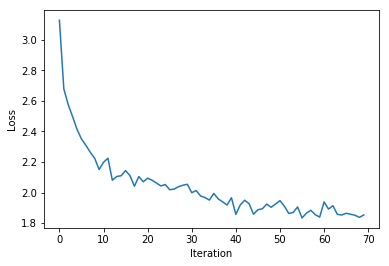

In [11]:
plt.figure()
plt.plot(all_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')

Below code prints all the names(a-z) generated

In [12]:
for i in range(len(ix_to_char)):
    print(sample(ix_to_char[i]))

aurusaurus
banosaurus
ceratops
donanosaurus
eratopsaurus
fanosaurus
ganianosaurus
hanosaurus
ianosaurus
janosaurus
kanosaurus
lanosaurus
manosaurus
natorantos
orantosaurus
panosaurus
qanosaurus
ratopanrosaurus
saurus
tanosaurus
uranosaurus
vanatorantos
wanosaurus
xanosaurus
yanosaurus
zanosaurus
